# Physics 453:  Solving the Double Finite Square Well

The Time Independent Schrodinger equation is
$$ E\Psi(x)=\left( \frac{-\hbar^2}{2m} \nabla^2 + V(x)\right) \Psi(x) $$
We will solve this equation numerically to obtain the energy eigenstates of the double finite square well, as in Problem 2.47 in Griffiths.  In one dimension, we can rearrange the equation to read
$$\psi''(x) =  -\frac{2m}{\hbar^2}\left[ E - V(x)\right]\psi(x)$$
Where for the double finite square well
$$V(x)=-V_0,\; \frac{b}{2}<|x|<\frac{b}{2}+a$$
$$V(x)=0,\; otherwise$$
We'll set $m=\hbar=1$, so that we must solve
$$\psi''(x) =  2\left[ V(x)-E\right]\psi(x)$$ 

#### Finite Differences
On a computer, we must work with discretized spatial grids.  Since the potential is symmetric, the eigenstates will be either symmetric or anti-symmetric, so we only have to solve for "half" of the wavefunction, from $x=0$ to some large $x=L$.  We will solve for the wavefunction on a discrete grid with $N$ points, defined by
$$ x_i = i\times\delta x$$
$$\delta x = \frac{L}{N}$$
Furthermore, we need to use finite differencing to calculate derivatives numerically on a discrete grid.  For example, the forward finite difference scheme for the first derivative is
$$\psi'(x_i) \approx \frac{\psi(x_{i+1})- \psi(x_i)}{\delta x}$$
While the backward differencing scheme is
$$\psi'(x_i) \approx \frac{\psi(x_{i})- \psi(x_{i-1})}{\delta x}$$
By using both the forward and backward differencing schemes, we can obtain what's called the second-order central difference approximation to the second derivative 

$$\psi''_i \approx (\psi'_i)'=\left( \frac{\psi_{i+1} - \psi_i}{\delta x} \right)'=\frac{(\psi_{i+1}-\psi_i) - (\psi_i - \psi_{i-1})}{\delta x^2}$$

$$\psi''_i \approx \frac{\psi_{i+1} - 2\psi_i + \psi_{i-1}}{\delta x ^2}$$
where $\psi_i=\psi(x_i)$.

#### Shooting Method
Let's plug our our expression for the discrete second order derivative into the Schrodinger equation. After rearranging a bit, we get
$$ \psi_{i+1} = 2\psi_i - \psi_{i-1} + 2\delta x^2 \left[ V(x_i) -E \right] \psi_i$$
The solutions are either symmetric or anti-symmetric, so either $\psi_0$ or $\psi_0'$ will be zero. Since 
$$\psi_1 \approx \psi_0 + \delta x \psi_0'$$
We can start with either $\psi_0$ or $\psi_0'$, and then use the previous two formulas to construct the rest of the wavefunction.  This is called the Shooting Method.

Note: How do we know $\psi_0$ or $\psi_0'$? Turns out, it doesn't matter! We just guess a value, and the only effect the value has is on the normalization of the resulting wavefunction, which we can easily correct. 

From our physical intuition (gained from Problem 2.47 in Griffiths), the ground state should be symmetric, with $\psi_0'=0$, while the first excited state will be anti-symmetric, with $\psi_0=0$. 




#### Obtaining the Energy
Wait, but what about the energy, $E$?  We don't know that either, but it appears as a parameter in the Shooting Method. Furthermore, although we can solve the Schodinger equation for any $E$, only very particular energies will yield physical, normalizable states.

Here's how we get around this: we start with an energy range, $E\in \left[E_{min}, E_{max} \right]$, which we think contains the physical states.  Then we search this range with a method like [bisection](https://en.wikipedia.org/wiki/Bisection_method) until we find the 'real' energy to an arbitrary degree of accuracy. Note:  The details of doing this are tricky! 

With this method, we'll never get exactly the right energy, which means the wavefunction will still be a bit off and blow up at large $x$.  But, we'll be so (arbitrarily) close to the right energy that the wavefunction near the double well will be extremely close to the right one. So, once we get to our desired accuracy, we just window the wavefunction, manually setting the values beyond a certain distance from the center of the wells to zero, and normalizing what remains.

In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.widgets import Slider, Button, RadioButtons
import numpy
import numpy.polynomial.hermite as Herm
import math

Small functions to get the double well potential and normalize wavefunctions.  
1. *Potential* takes an array of the grid points and returns an array of the same length with the values of the potential at each point, $V(x_i)=V_i$.  
*    *norm* takes an array of values for the wavefunction $\psi(x_i)=\psi_i$ and returns its norm, $\int \psi^2dx \approx \sum_i \psi_i^2 \delta x$. 
*    *normalize* will normalize the wavefunction so that $\sum_i \psi_i^2 \delta x=1$.

In [2]:
def Potential(x, a, b, V0):
    V=numpy.zeros(len(x))
    V[(abs(x)>=b/2.) & (abs(x)<b/2.+a)] = -V0
    return V

def norm(dx, psi):
    return dx*numpy.dot(psi,psi)

def normalize(dx, psi):
    return psi/numpy.sqrt(norm(dx,psi))


This is the meat of the program.  Starting with the value of the wavefunction and its derivative at $x=0$, we use the shooting method to calculate the rest of the wavefunction iteratively, changing the energy until we find an acceptable solution.

In [3]:
def forward_shooting(V, x, dx, f0, df0, Emin, Emax, acc):
    """
    V - array with the values of the potential at the points in x
    x - the grid points
    dx - the spacing of the grid
    f0 - value of the funtion at x=0
    df0 - value of the derivative of the function at x=0
    Emin, Emax - the energy window in which to search for physical solutions
    acc - find the energy to within this accuracy, smaller accuracy will require more iterations
    """
    Edelta = 1.
    E = Emin
    psi = numpy.zeros(len(x))
    psi[0]=f0
    max_steps = 500
    count=0
    
    #Find the energy corresponding to a physical state via bisection
    #Keep iterating until we have the energy to within acc, or until we take max_steps iterations
    while Edelta > acc and count < max_steps:
        count+=1
        #Step through the grid points and find the value of the wavefunction from the shooting method
        for i, x_ in enumerate(x[0:-1]):
            if i==0:
                psi[i+1] = psi[i] + dx*df0
            else:
                psi[i+1] = -psi[i-1] + 2.*( 1 + dx**2 * (V[i] - E) )*psi[i]
                
            #This is the tricky part! If the wavefunction is blowing up,
            #we use bisection to change the energy and search for the physical energy.
            #The details of how to pick the next energy depend on number of nodes the wavefunction has.  
            #This will work for n=0,1,4,5,8,9...
            if(psi[i] > 25):
                Emin=E
                E = Emin + (Emax-Emin)/2.
                break
            elif(psi[i] < -25):
                Emax=E
                E=Emax-(Emax-Emin)/2.
                break
        Edelta = (Emax-Emin)
    return (psi, E)
    

This function just nicely wraps everything up: when we call it with the double well parameters, we get the ground and first excited states back, plus their energies.

In [4]:
def acquire_double_well_states(a, b, V0, x, dx, acc, L_plot):
    V = Potential(x, a, b, V0)
    
    #Get the ground state (symmetric, psi'(x=0)=0)
    (psi_0, energy_0) = forward_shooting(V, x, dx, 1, 0, -V0, 0, acc)
    
    #Get the first excited state (antisymmetric, psi(x=0)=0)
    (psi_1, energy_1) = forward_shooting(V, x, dx, 0, 1, -V0, 0, acc)
    psi_0[x>L_plot]=0
    psi_1[x>L_plot]=0

    #Use symmetry to get the other half of the wavefunction
    space = numpy.zeros(2*len(x))
    space[0:len(x)]=-x[::-1]
    space[len(x):2*len(x)]=x

    Psi_0 = numpy.zeros(len(space))
    Psi_0[0:len(x)]=psi_0[::-1]
    Psi_0[len(x):2*len(x)]=psi_0
    Psi_0=normalize(dx, Psi_0)

    Psi_1 = numpy.zeros(len(space))
    Psi_1[0:len(x)]=psi_1[::-1]
    Psi_1[len(x):2*len(x)]=-psi_1
    Psi_1=normalize(dx, Psi_1)
    
    return (space, Psi_0, energy_0, Psi_1, energy_1)
    

Let's check the solutions for a particular $b$.  Notice that both states are properly normalized.

Norm Psi_0= 1.0
Energy_0= -1.6805031159892678
Norm Psi_1= 1.0
Energy_1= -0.8209590911865234


<IPython.core.display.Javascript object>


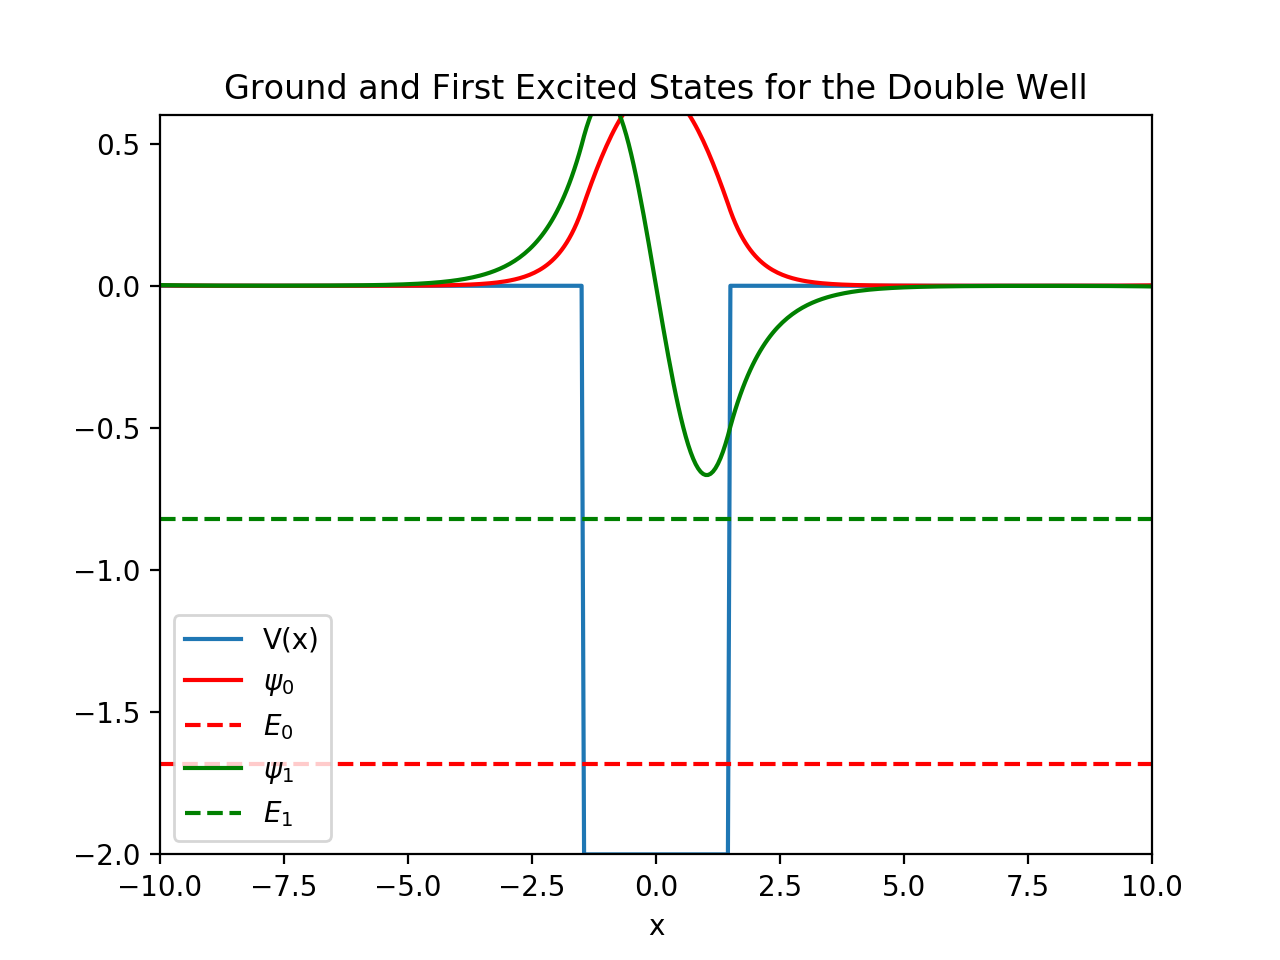

In [5]:
a=1.5
b=0
V0=2
dx=0.05
acc=1e-10
L=10*(b+a)
L_plot=10
x=numpy.linspace(0,L,L/dx+1,True)

(space, Psi_0, energy_0, Psi_1, energy_1) = acquire_double_well_states(a, b, V0, x, dx, acc, L_plot)

print("Norm Psi_0=",norm(dx, Psi_0))
print("Energy_0=", energy_0)
print("Norm Psi_1=",norm(dx, Psi_1))
print("Energy_1=", energy_1)

plt.subplots()
plt.plot(space, Potential(space, a, b, V0), label="V(x)")

plt.plot(space, Psi_0, 'r',label="$\psi_0$")
plt.plot([-L_plot,L_plot], [energy_0,energy_0],'r--',label="$E_0$")
plt.plot(space, Psi_1, 'g',label="$\psi_1$")
plt.plot([-L_plot,L_plot], [energy_1,energy_1],'g--',label="$E_1$")

plt.xlim([-L_plot,L_plot])
plt.ylim([-2,0.6])
plt.legend(loc=3)
plt.title('Ground and First Excited States for the Double Well')
plt.xlabel('x')
plt.show()

Now let's create an interactive plot, where we can change the well separation, $b$, and see how the states and energies change.

<IPython.core.display.Javascript object>


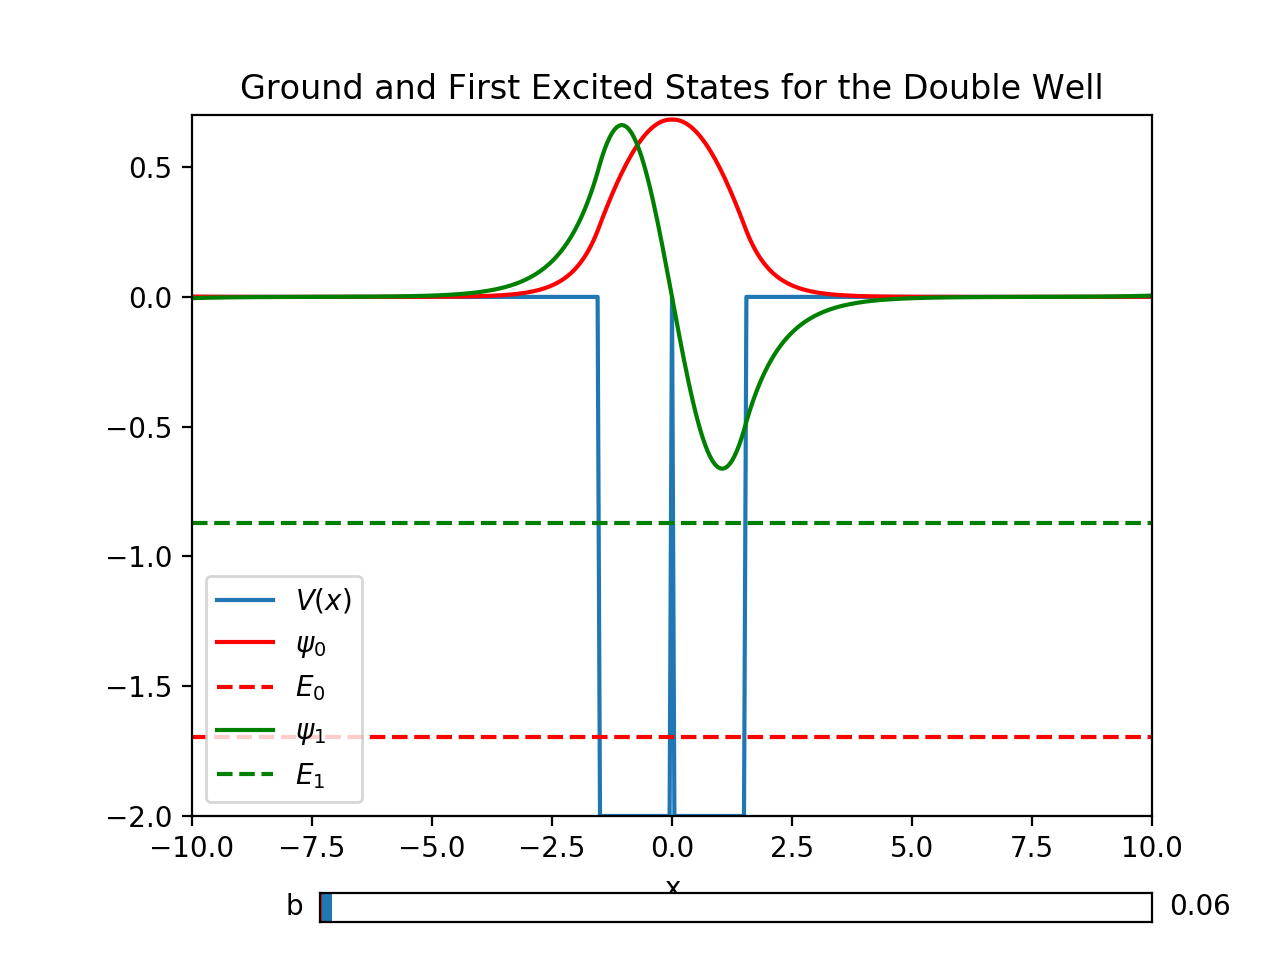

In [12]:
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.15, bottom=0.15)

#Set up an initial solution to plot
b0=0
(space, Psi_0, energy_0, Psi_1, energy_1) = acquire_double_well_states(a, b0, V0, x, dx, acc, L_plot)

pot, = plt.plot(space, Potential(space, a, b0, V0), label="$V(x)$")
state_0, = plt.plot(space, Psi_0, 'r',label="$\psi_0$")
E0, = plt.plot([-L_plot,L_plot], [energy_0,energy_0],'r--',label="$E_0$")
state_1, = plt.plot(space, Psi_1, 'g',label="$\psi_1$")
E1, = plt.plot([-L_plot,L_plot], [energy_1,energy_1],'g--',label="$E_1$")

plt.xlim([-L_plot,L_plot])
plt.ylim([-2,0.7])
plt.legend(loc=3)
plt.title('Ground and First Excited States for the Double Well')
plt.xlabel('x')

#Add a slider to interactively change the well separation, b
axb = plt.axes([0.25, 0.04, 0.65, 0.03])
sb = Slider(axb, 'b', 0., 4., valinit = b0)

#When we move the slider, calculate the solutions for the new b
def update(val):
    bnew = sb.val
    (space, Psi_0, energy_0, Psi_1, energy_1) = acquire_double_well_states(a, bnew, V0, x, dx, acc, L_plot)
    pot.set_ydata(Potential(space, a, bnew, V0))
    state_0.set_ydata(Psi_0)
    E0.set_ydata([energy_0,energy_0])
    state_1.set_ydata(Psi_1)
    E1.set_ydata([energy_1,energy_1])
    
sb.on_changed(update)

plt.show()

#### References
1. [Shooting Method for Double Well](https://nbviewer.jupyter.org/urls/www.numfys.net/media/notebooks/eigenenergies_double_well_potential.ipynb), Henning G. Hugdal, Magnus H-S Dahle and Peter Berg

### Appendix
Here we check the energies for the single well (spacing of zero) and that the normalization is correct.

Norm Psi_0= 1.0
Energy_0= -1.6805031159892678
Norm Psi_1= 1.0
Energy_1= -0.8209590911865234


<IPython.core.display.Javascript object>


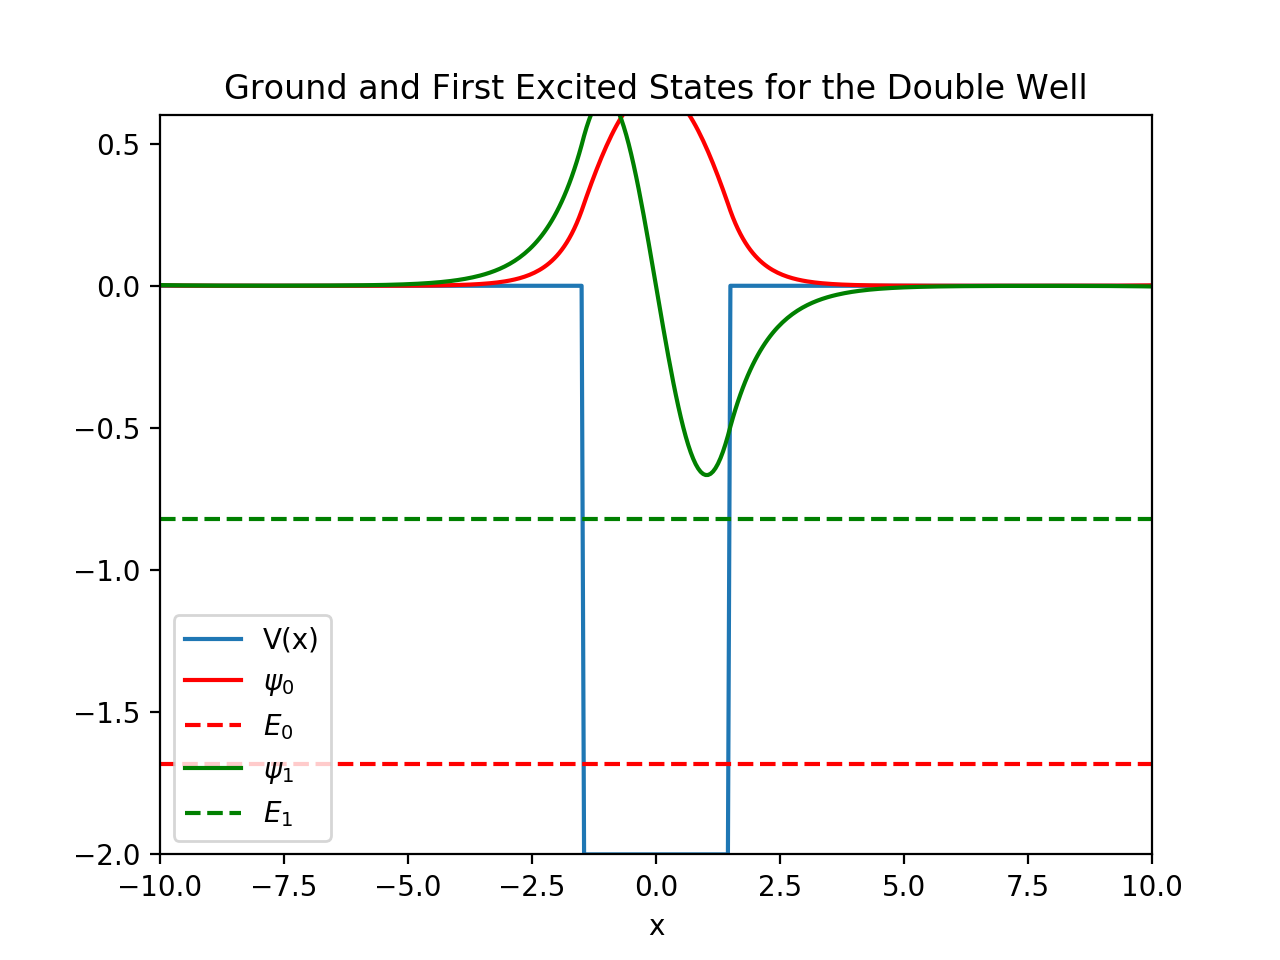

In [7]:
a=1.5
(space, Psi_0, energy_0, Psi_1, energy_1) = acquire_double_well_states(a, 0, V0, x, dx, acc, L_plot)

print("Norm Psi_0=",norm(dx, Psi_0))
print("Energy_0=", energy_0)
print("Norm Psi_1=",norm(dx, Psi_1))
print("Energy_1=", energy_1)

plt.subplots()
plt.plot(space, Potential(space, a, b, V0), label="V(x)")

plt.plot(space, Psi_0, 'r',label="$\psi_0$")
plt.plot([-L_plot,L_plot], [energy_0,energy_0],'r--',label="$E_0$")
plt.plot(space, Psi_1, 'g',label="$\psi_1$")
plt.plot([-L_plot,L_plot], [energy_1,energy_1],'g--',label="$E_1$")

plt.xlim([-L_plot,L_plot])
plt.ylim([-2,0.6])
plt.legend(loc=3)
plt.title('Ground and First Excited States for the Double Well')
plt.xlabel('x')
plt.show()